# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [18]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Define the Architecture of the Policy

In [19]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


In [24]:
## some test code
## Don't run this cell unless you want to test
policy = Policy().to(device)

print(policy)

saved_log_probs = []
rewards = []
state = env.reset()
for t in range(30):
    action, log_prob = policy.act(state)
    saved_log_probs.append(log_prob)
    print("action: {} - log_prob: {} ".format(action, log_prob))
    state, reward, done, _ = env.step(action)
    print("state: {}".format(state))
    print("reward: {}".format(reward))
    rewards.append(reward)
    if done:
        break

Policy(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
action: 0 - log_prob: tensor([-0.5448]) 
state: [-0.00384741 -0.15415638 -0.04506642  0.32006918]
reward: 1.0
action: 1 - log_prob: tensor([-0.8489]) 
state: [-0.00693053  0.04157745 -0.03866504  0.0135215 ]
reward: 1.0
action: 0 - log_prob: tensor([-0.5423]) 
state: [-0.00609898 -0.15296928 -0.03839461  0.29375879]
reward: 1.0
action: 0 - log_prob: tensor([-0.5571]) 
state: [-0.00915837 -0.34752339 -0.03251943  0.57408965]
reward: 1.0
action: 0 - log_prob: tensor([-0.5565]) 
state: [-0.01610884 -0.54217469 -0.02103764  0.8563532 ]
reward: 1.0
action: 0 - log_prob: tensor([-0.5554]) 
state: [-0.02695233 -0.73700377 -0.00391057  1.14234753]
reward: 1.0
action: 1 - log_prob: tensor([-0.8546]) 
state: [-0.04169241 -0.54183093  0.01893638  0.84844081]
reward: 1.0
action: 0 - log_prob: tensor([-0.5554]) 
state: [-0.05252903 -0.73720597  0.03590519  1.14701778]
rewa

### 3. Train the Agent with REINFORCE

In [27]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)] #Discount expression builder
        R = sum([a*b for a,b in zip(discounts, rewards)])     #Discounted total reward for this episode
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)       
        policy_loss = torch.cat(policy_loss).sum()  #Policy gradient in this episode
        
        #print("policy_loss")
        #print(policy_loss)
        
        #Update the weights of the policy now
        optimizer.zero_grad()
        policy_loss.backward()  
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 32.00
Episode 200	Average Score: 65.08
Episode 300	Average Score: 59.34
Episode 400	Average Score: 58.88
Episode 500	Average Score: 59.70
Episode 600	Average Score: 65.22
Episode 700	Average Score: 74.79
Episode 800	Average Score: 93.94
Episode 900	Average Score: 52.78
Episode 1000	Average Score: 80.86


### 4. Plot the Scores

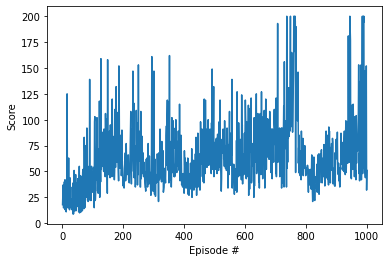

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

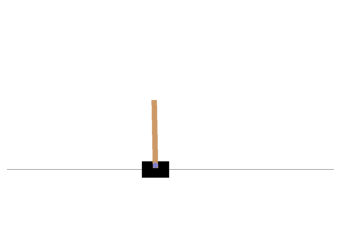

In [29]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()